---
title: "Post 5 - Implementing Logistic Regression"
author: Col McDermott
date: "04-9-2025"
description: "An introductory exploration of logistic regression and gradient descent."
format: html
code-fold: true
execute:
  warning: false
  message: false
---

# Abstract

The main purpose of this brief study is to implement from scratch and investigate the procedures under the hood of logistic regression.  Logistic regression is a well-known machine-learning method used primarily for binary classification.  This widely-recognized ML technique involves several common ML algorithm characteristics such as a linear model, model scores, a weights vector, and the corresponding empirical risk optimization problem.  This base-level analysis of logistic regression serves to develop a general understanding of many common ML binary classification architectures as well as introduce several relevant topics exercised and enhanced in more advanced ML algorithms.  

The optimization problem in logistic regression aims to find the specific weights vector that minimizes the "loss" of the linear model and is solved using a gradient descent procedure.  This introductory exploration of logistic regression involves implementing a basic linear model with a corresponding weights vector, designing a linear regression object to compute the empirical risk loss values and corresponding gradients, and a gradient descent optimizer that performs the weights vector optimization task.

To analyze my version of logistic regression, I have conducted the following experiments on my implementation:

1. Evaluating a standard gradient descent procedure to optimize the weights vector of the linear model to achieve high classification accuracy.  
2. Evaluating a gradient descent method *with momentum* to achieve faster convergence (i.e. optimizing the weights vector to minimize the empirical risk) than standard gradient descent.
3. Exploring overfitting in which logistic regression is used to produce a linear model and a weights vector that performs flawlessly on training data but less well on unseen testing data.  
4. Evaluating the efficacy of my logistic regression implementation on real-world, empirical data (using standard train-test-split, model fitting, and model scoring methods).

For my implementation of logistic regression, check out [logistic.py](https://github.com/Col-McDermott/Col-McDermott.github.io/blob/main/posts/post_5/logistic.py).

## Implementing Logistic Regression

In [1]:
# Including all additional imports
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import torch as tch
import pandas as pd
import numpy as np

# Porting over logistic regression implementation
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer
tch.manual_seed(100) # For consistent data generation
plt.style.use('seaborn-v0_8-whitegrid') # For consistent plotting

For this introductory study, I have implemented a rudimentary version of logistic regression.  This implementation involves three class definitions: `LinearModel`,   `LogisticRegression`, and `GradientDescentOptimizer`.

**`LinearModel`**:

-   `self.w`: An instance variable to store the weights vector $\mathbf{w}$ of a linear model.
-   `score(X)`: A method to compute the score $s_i$ for each data point in the feature matrix **$X$** using:
$$
s_i = \langle\mathbf{w}, x_i\rangle
$$
-   `predict(X)`: A method to compute the vector of classification predictions $\hat{y}$ for each data point in the feature matrix **$X$**:
$$
    \hat{y}_i = \begin{cases}
    1 & \text{if} & s_i > 0.5\\
    0 & \text{else} 
\end{cases}
$$

**`LogisticRegression`** (inherits from **`LinearModel`**):

- `sig(x)`: A method that represents the logistic sigmoid function.  This method computes the vector of values $\sigma(x_i)$ given an vector of inputs $\mathbf{x}$:
$$
\sigma(x_i) = \frac{1}{1 + e^{-x_i}}
$$
-   `loss(X, y)`: A method to compute the empirical risk $L(\mathbf{w})$ using the logistic loss function.  Note that the scores are computed using **$X$** and the loss computation involves $\mathbf{y}$. The returned value is a scalar/real number that gives a quantitative measure of the empirical risk:
$$
L(\mathbf{w}) = \frac{1}{n}\sum_{i = 1}^n{[-y_ilog(\sigma(s_i)) - (1 - y_i)log(1 - \sigma(s_i))]}
$$ 
-   `grad(X, y)`: A method to compute the gradient $\nabla L(\mathbf{w})$ of the empirical risk function $L(\mathbf{w})$.  Note that the scores are computed using **$X$** and the gradient computation involves $\mathbf{y}$.  The returned value is a vector with $p$ entries that represents the direction and rate of change of the empirical risk function given the current weights vector $\mathbf{w}$.  Ultimately, this method computes the gradient used to perform a step of gradient descent in logistic regression:
$$
\nabla L(\mathbf{w}) = \frac{1}{n}\sum_{i = 1}^n{(\sigma(s_i) - y_i)x_i}
$$

**`GradientDescentOptimizer`**:

-   `self.lr`: An instance variable of a `LogisticRegression` object.  This variable is used to access the implicit model's current weights vector $\mathbf{w_k}$ during a gradient descent step.
-   `self.prev_w`: An instance variable of the previous weights vector $\mathbf{w_{k-1}}$ (initialized to `self.lr.w`).  This variable is used to access the model's previous weights vector $\mathbf{w_{k-1}}$ during a gradient descent step.
-   `step(X, y, alpha, beta)`: A method that computes a step of gradient descent *with momentum*.  This method performs the optimization update to $\mathbf{w}$ using the gradient of the `LogisticRegression` object (which needs **$X$** and $\mathbf{y}$).  The arguments `alpha` and `beta` are hyperparameters for the optimization update; $\alpha$ is the learning rate and $\beta$ is the momentum scalar.  The update to the weights vector $\mathbf{w}$ performed by this method is:
$$
\mathbf{w_{k+1}} = \mathbf{w_{k}} - \alpha\nabla L(\mathbf{w}) + \beta(\mathbf{w_k} - \mathbf{w_{k-1}})
$$

## Experimenting With Logistic Regression

In order to conduct some basic experiments with my logistic regression implementation, it is necessary to generate some simulated data for a binary classification problem.  This experiment data is generated and visualized in the code cell below:

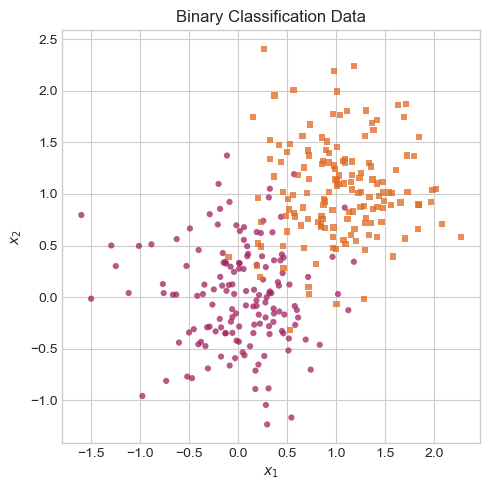

In [2]:
# Generating data for binary classification - code provided by Prof. Chodrow
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    y = tch.arange(n_points) >= int(n_points / 2)
    y = 1.0 * y
    X = y[:, None] + tch.normal(0.0, noise, size = (n_points,p_dims))
    X = tch.cat((X, tch.ones((X.shape[0], 1))), 1)
    
    return X, y
X, y = classification_data(noise = 0.5)

# Visualizing the generated data above
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
targets = [0, 1]
markers = ["o" , ","]

# Custom color map
colors = ["purple", "darkorange"]  
cmap = LinearSegmentedColormap.from_list("my_cmap", colors, N = 256)

# Some code provided by Prof. Chodrow
for i in range(2):
    ix = y == targets[i]
    ax.scatter(X[ix, 0], X[ix, 1], s = 20,  c = 2 * y[ix] - 1, facecolors = "none", edgecolors = "none", cmap = cmap, vmin = -2, vmax = 2, alpha = 0.75, marker = markers[i])
ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
ax.set_title("Binary Classification Data")
plt.tight_layout()

*Code above generates some random binary classification data and visualizes the generated data (some code provided by Prof. Chodrow).*

**Figure 1**

Above is a visualization of the generated binary classification data.  While the data above does not appear to be highly conducive to perfectly separable decision boundaries, it still displays clear general regions of the two groups of data points.

In [3]:
# Model interpretation helper methods
## Loss value plotter
def loss_plot(loss_vec1, loss_vec2 = None):
    
    # Plotting the loss values of the model across each optimization iteration
    fig, ax = plt.subplots(1, 1, figsize = (5, 5))
    ax.plot(loss_vec1, color = "purple", linewidth = 2)
    title = "Evolution of Empirical Loss Value"
    if (loss_vec2 != None):
        title = "Gradient Descent Method Comparison\nof Empirical Loss Value Convergence"
        ax.plot(loss_vec2, color = "darkorange", linewidth = 2)
        ax.legend(["Standard", "Momentum"], frameon = True)
        ax.axhline(loss_vec2[-2], color = "black", linestyle = "--")
    ax.set_title(title)
    ax.set_xlabel("Optimization Iteration")
    ax.set_ylabel("Loss")
    plt.tight_layout()

# Model accuracy plotter
def acc_plot(accs1, accs2 = None):
    
    # Plotting the accuracies of the model across each optimization iteration
    fig, ax = plt.subplots(1, 1, figsize = (5, 5))
    ax.plot(accs1, color = "purple", linewidth = 2)
    if (accs2 != None):
        ax.plot(accs2, color = "darkorange", linewidth = 2)
        ax.legend(["Training Accuracy", "Testing Accuracy"], frameon = True)
    ax.set_title("Model Accuracy Across Optimization Iteration")
    ax.set_xlabel(r"Gradient Descent Iteration")
    ax.set_ylabel("Accuarcy")
    plt.tight_layout()

# Decision line plotting helper method - code provided by Prof. Chodrow
def draw_line(X, w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = tch.linspace(x_min, x_max, X.shape[0])
    y = -1 * (((w_[0] * x) + w_[2])/w_[1])
    ax.plot(x, y, **kwargs)

# Decision region plotter
def decision_bound(model, X, y):

    # Creating a mesh grid
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    fig, ax = plt.subplots(1, 1, figsize = (5, 5))
    
    # Drawing the decision line
    draw_line(X, model.w, x_min, x_max, ax, color = "slategray", linewidth = 2)
    targets = [0, 1]
    markers = ["o" , ","]

    # Custom color map
    colors = ["purple", "darkorange"]  
    cmap = LinearSegmentedColormap.from_list("my_cmap", colors, N=256)

    # Some code below provided by Prof. Chodrow
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix, 0], X[ix, 1], s = 20,  c = 2 * y[ix] - 1, facecolors = "none", edgecolors = "none", cmap = cmap, vmin = -2, vmax = 2, alpha = 0.75, marker = markers[i])
    
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    ax.set_title("Decision Regions of Logistic Regression Model")
    ax.text(X[:, 0].max() * 0.8, X[:, 1].max() * 0.85, f"Model Accuracy:\n{round(acc(model, X, y), 4) * 100}%", fontsize = 10, ha = "center", bbox = dict(facecolor = "white", alpha = 0.75, edgecolor = "gray", boxstyle = "round,pad = 0.3"))
    plt.tight_layout()

# Function to calculate model accuracy
def acc(model, X, y):
    
    # Compute model predictions
    preds = model.predict(X)

    # Determine the number of correct predictions
    correct_preds = ((preds == y) * 1).float()

    # Return the rate of correct predictions
    return tch.mean(correct_preds).item()

*Code above defines plotting methods for observing the model's empirical loss value evolution, the model's accuracy, and the model's classification decision boundaries (some code provided by Prof. Chodrow).*

### Experiment 1: Standard Gradient Descent

In [4]:
# Testing vanilla gradient descent - some code provided by Prof. Chodrow
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

# Keeping track of the initial model accuracy
it = 100
losses = []
accs = []
for i in range(it):
    
    # Recording current loss value and model accuracy
    losses.append(LR.loss(X, y))
    accs.append(acc(LR, X, y))

    # Displaying gradient descent progress for the first 5 iterations
    if (i % 20 == 0) & (i < 100):
        print(f"Iteration {i}:")
        print(f"Current Loss value: {round(losses[-1], 3)}")
        print(f"Current Model Accuracy: {round(accs[-1], 4) * 100}%\n")
    opt.step(X, y, alpha = 0.1, beta = 0)

print("...\n")
print(f"Iteration {it}:")
print(f"Final Loss value: {round(losses[-1], 3)}")
print(f"Final Model Accuracy: {round(accs[-1], 4) * 100}%")

Iteration 0:
Current Loss value: 0.861
Current Model Accuracy: 89.33%

Iteration 20:
Current Loss value: 0.734
Current Model Accuracy: 91.67%

Iteration 40:
Current Loss value: 0.646
Current Model Accuracy: 92.33%

Iteration 60:
Current Loss value: 0.583
Current Model Accuracy: 92.33%

Iteration 80:
Current Loss value: 0.536
Current Model Accuracy: 92.67%

...

Iteration 100:
Final Loss value: 0.501
Final Model Accuracy: 92.67%


*Code above conducts a standard gradient descent procedure with $100$ iterations using `LogisticRegression` and `GradientDescent` objects and outputs the results of every 20th iteration (some code provided by Prof. Chodrow)*

The output above highlights the model's empirical loss value and accuracy at every 20th iteration ($100$ iterations total) during a standard gradient descent procedure.  Over the optimization iterations displayed above, the model's empirical loss value decreases while its accuracy increases.

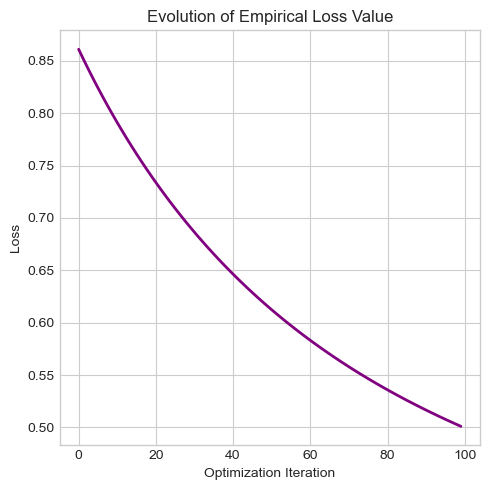

In [5]:
# Visualizing standard gradient descent
loss_plot(losses)

*Code above plots the evolution of the model's empirical loss value across the optimization iterations of standard gradient descent.*

**Figure 2**

As further shown in the figure above, the model's empirical loss value decreases across each iteration of the optimization process.  The initial empirical loss value is approximately $0.86$ while the post-optimization loss value is about $0.5$, indicating a ~$48\%$ loss-value decrease.  This suggests that my implementation of logistic regression works as is generally expected.  That is, during a standard gradient procedure, the current linear model's weights vector $\mathbf{w}$ yields a lower empirical loss value than that of the previous model during each iteration of optimization.

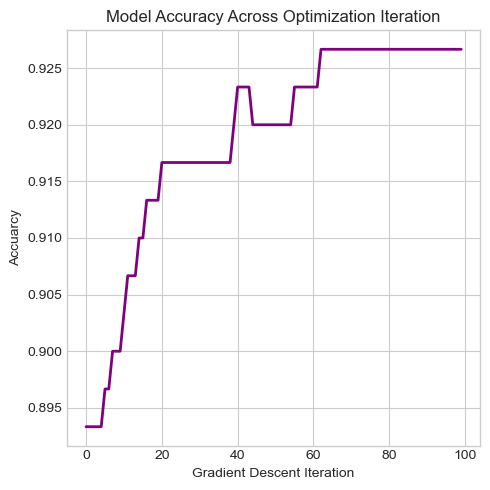

In [6]:
# Plotting the evolution of the model accuracy
acc_plot(accs)

*Code above plots the model accuracy at each iteration of the standard gradient descent procedure above.*

**Figure 3**

As displayed above, the accuracy of the model generally increases with each iteration of the gradient procedure, climbing from ~$89\%$ to ~$93\%$ accuracy.  This aligns with the fact that the empirical loss value of the model is shown to decrease with each iteration of gradient descent.  That is, the model's accuracy and its empirical loss value are inversely related.

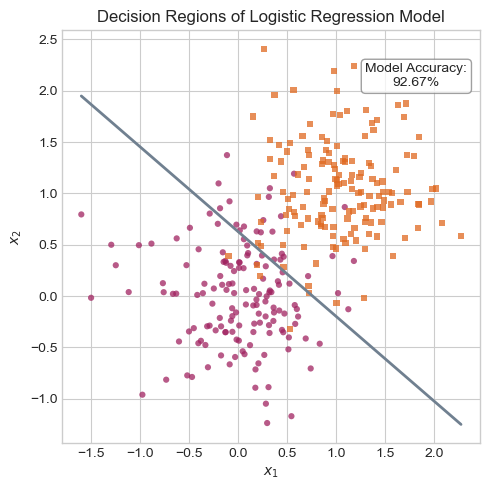

In [7]:
# Plotting the decision boundaries
decision_bound(LR, X, y)

*Code above plots the data along with the separation line of the refined model (displaying the model accuracy as well).*

**Figure 4**

The figure above depicts the classification decision boundary of the refined model.  While the classification line does not indicate flawless classification for *all* data points, it illustrates correct classification for most of the data.  This is supported by the model's fairly high ~$93\%$ accuracy.

### Experiment 2: Gradient Descent With Momentum

In [8]:
# Testing gradient descent with momentum - some code provided by Prof. Chodrow
LR_v = LogisticRegression()
opt_v = GradientDescentOptimizer(LR_v) # Vanilla gradient descent optimizer
LR_m = LogisticRegression()
opt_m = GradientDescentOptimizer(LR_m) # Momentum gradient descent optimizer

# Arrays to store the loss values of the models optimized with and without momentum
losses_v = []
losses_m = []
at_tol = False
i = 0

# Iteration counters to track convergence
v_i = np.iinfo(np.int64).max
m_i = np.iinfo(np.int64).max
while (at_tol != True):
    
    # Recording current loss value and model accuracy
    loss_v = LR_v.loss(X, y)
    loss_m = LR_m.loss(X, y)
    if (loss_v > 0.3):
        losses_v.append(loss_v)
        opt_v.step(X, y, alpha = 0.1, beta = 0)
    elif (v_i > i):
        v_i = i
    if (loss_m > 0.3):
        losses_m.append(loss_m)
        opt_m.step(X, y, alpha = 0.1, beta = 0.9)
    elif (m_i > i):
        m_i = i
    
    # Terminating condition
    if (loss_v < 0.3) & (loss_m < 0.3):
        at_tol = True
    
    # Displaying gradient descent progress for the first 5 iterations
    if (i % 20 == 0) & (i < 100):
        print(f"Iteration {i}:")
        print(f"Current Loss value (Standard Gradient Descent): {round(losses_v[-1], 3)}")
        print(f"Current Loss value (Momentum Gradient Descent): {round(losses_m[-1], 3)}\n")
    i += 1

print("...\n")
print(f"Standard Gradient Descent Converges at {v_i} Iterations")
print(f"Momentum Gradient Descent Converges at {m_i} Iterations")

Iteration 0:
Current Loss value (Standard Gradient Descent): 0.749
Current Loss value (Momentum Gradient Descent): 0.982

Iteration 20:
Current Loss value (Standard Gradient Descent): 0.651
Current Loss value (Momentum Gradient Descent): 0.437

Iteration 40:
Current Loss value (Standard Gradient Descent): 0.584
Current Loss value (Momentum Gradient Descent): 0.311

Iteration 60:
Current Loss value (Standard Gradient Descent): 0.535
Current Loss value (Momentum Gradient Descent): 0.301

Iteration 80:
Current Loss value (Standard Gradient Descent): 0.498
Current Loss value (Momentum Gradient Descent): 0.301

...

Standard Gradient Descent Converges at 576 Iterations
Momentum Gradient Descent Converges at 47 Iterations


*Code above initializes `LogisticRegression` and `GradientDescentOptimizer` objects for both standard gradient descent and gradient descent with momentum optimizers.  The output above shows convergence progress every $20$ iterations and depicts the number of optimization iterations needed for each gradient descent process to achieve a loss value $< 0.3$ (some code provided by Prof. Chodrow).*

In this experiment, I compare the rate of convergence between the standard gradient descent and gradient descent with momentum procedures.  For this experiment, I loosely define "convergence" to be when the optimized model's empirical loss value is $< 0.3$.  Note that for this analysis, I have set the hyperparameters to $\alpha_s, \alpha_m = 0.1$ for both optimizers and $\beta_s = 0$ (standard gradient descent), $\beta_m = 0.9$ (gradient descent with momentum).  As presented in the output above, the gradient descent with momentum optimizer achieves a loss value $< 0.3$ in significantly fewer iterations than that of the standard gradient descent optimizer.  That is, the gradient descent with momentum process appears to converge in about $\frac{1}{12}$ of the iterations needed for the standard gradient descent process to converge.  

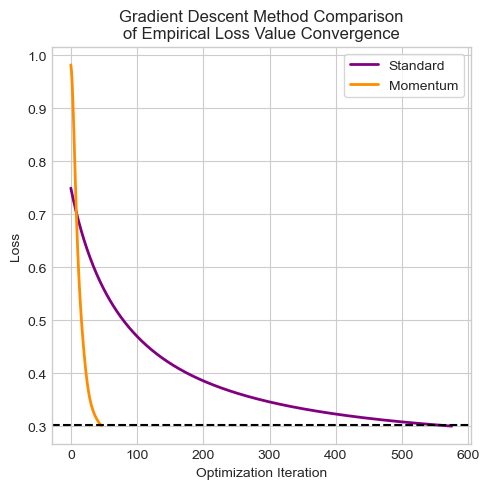

In [9]:
# Comparing the convergence rates of the two gradient descent methods
loss_plot(losses_v, losses_m)

*Code above plots the convergence rates of the empirical loss values for both the standard gradient descent and gradient descent with momentum procedures.*

**Figure 5**

This figure above is a visual accompaniment to the output from above.  In line with the aforementioned output, the gradient descent with momentum optimizer clearly converges to the tolerance ($< 0.3$) empirical loss value rapidly quicker (at $47$ iterations) than the standard gradient descent optimizer (at $576$ iterations).  

### Experiment 3: Investigating Overfitting

To observe an instance of my logistic regression implementation leading to overfitting, I have generated two new sets of binary classification data.  The two new data sets are identically designed, where the number of features per data point exceeds the number of data points.  One dataset will be used as the "training data" and the other the "testing data".

In [10]:
# Generating binary classification data for overfitting - code provided by Prof. Chodrow
X_train, y_train = classification_data(n_points = 50, noise = 0.5, p_dims = 100)
X_test, y_test = classification_data(n_points = 50, noise = 0.5, p_dims = 100)

*Code above generates the "training" and "testing" data sets for the overfitting experiment (some code provided by Prof. Chodrow).*

In [11]:
# Investigating overfitting as the number of dimensions in the data grows past the number of data points
LR  = LogisticRegression()
opt = GradientDescentOptimizer(LR)

# Current accuracy variable
accs = []
tst_accs = []
curr_acc = 0
j = 0
while (curr_acc < 1.0):
    
    # Calculating the current model accuracy
    curr_acc = acc(LR, X_train, y_train)
    tst_acc = acc(LR, X_test, y_test)
    accs.append(curr_acc)
    tst_accs.append(tst_acc)
    opt.step(X_train, y_train, alpha = 0.1, beta = 0.9) # Using gradient descent with momentum
    
    # Iteration counter
    j+= 1

print(f"Model Achieved 100.0% Accuracy on Training Data in {j} Iterations (Gradient Descent w/ Momentum)")
print(f"Model Accuracy on Testing Data: {round(tst_accs[-1], 4) * 100}%")

Model Achieved 100.0% Accuracy on Training Data in 14 Iterations (Gradient Descent w/ Momentum)
Model Accuracy on Testing Data: 86.0%


*Code above conducts a model overfitting experiment by first setting the number of data features to be greater than the number of data points, then fitting a model using `LogisticRegression` and `GradientDescentOptimizer` objects, and finally comparing the model's training-data performance to its testing-data performance.* 

As indicated by the output above, the logistic regression model is able to achieve maximum classification accuracy on the training data in a fairly small number of iterations.  However, when evaluated on the unseen testing data, the model's accuracy drops significantly to about $86\%$.  This is clear sign of overfitting as the model's flawless performance on the training data does not translate to its performance on the testing data.   

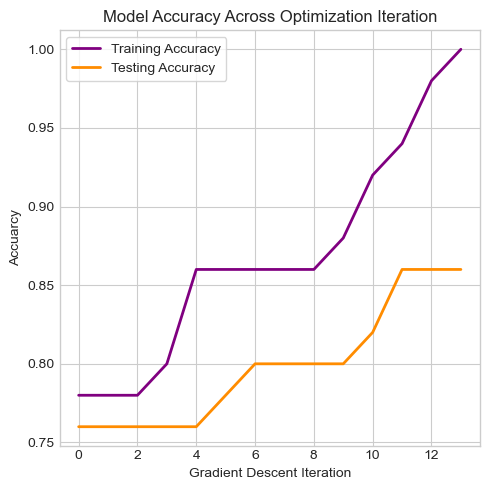

In [12]:
# Plotting the model's training and testing accuracies as training accuracy approaches 100%
acc_plot(accs, tst_accs)

*Code above plots the model's training and testing accuracies at each iteration of optimization during the overfitting experiment.*

**Figure 6**

As shown in the above figure, the model's training accuracy climbs all the way to $100\%$ while its testing accuracy plateaus at around $86\%$ and does not increase further (in $14$ iterations).  This figure stands as a visual representation of how the model is overfitting to the training data and consequently sacrificing performance on the unseen testing data.

### Experiment 4: Evaluating The Performance of `LogisticRegression` and `GradientDescentOptimizer` on Empirical Data

The final experiment in this brief study involves evaluating the performance of my logistic regression implementation on real-world data.  For this experiment, I will be using a public data set published to [kaggle.com](https://www.kaggle.com/datasets/juice0lover/users-vs-bots-classification?resource=download) by Aleksei Zagorskii.  This dataset contains user profile data from the popular Russian social media and networking platform VKontakte ([VK.com](https://vk.com/)) and is used to classify users as either real-human users or bots.  The data features a combination of numerical and categorical information extracted from public *VK.com* user profiles.

In [13]:
# Reading-in and processing the data to evaluate the model with
df = pd.read_csv("./bots_vs_users.csv")

# Selecting a subset of the features to use - selecting only the features with float64 data types
cols = []
for col in df.columns:
    if (df[col].dtype == "float64"):
        cols.append(col)
cols.append("target")
df_pruned = df[cols].copy()
df_pruned = df_pruned.dropna() # Dropping any rows with missing values

# Converting the dataframe into tch.tensors
X = tch.tensor(df_pruned[cols[:-1]].values).float()
y = tch.tensor(df_pruned[cols[-1]].values).float()

# Normalizing the data through standardization to ensure effective and expected behavior from logistic regression
mean = tch.mean(X, dim = 0, keepdim = True)
std = tch.std(X, dim = 0, keepdim = True)
X_s = (X - mean) / std

# Splitting the data into training (60%) and testing/validation (40%) data
X_train, X_tmp, y_train, y_tmp = train_test_split(X_s, y, test_size = 0.4, random_state = 1, stratify = y)

# Splitting the testing/validation data into testing (50%, 20% overall) and validation (40%, 20% overall) data
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size = 0.5, random_state = 1, stratify = y_tmp)


*Code above imports the dataset used for this experiment, preprocesses it by extracting only the columns with a `float64` data type, converts the data into `tch.tensors` for the feature matrix $\mathbf{X}$ and the target vector $\mathbf{y}$, and standardizes the data to ensure expected logistic regression behavior and avoid machine-precision error.  Finally, I conduct a test-train-split procedure to split the data into $60\%$ for training, $20\%$ for validation, and $20\%$ for testing.*

Originally, the full dataset contained $60$ features, many of which have missing values (`NaN`, or `"Unknown"`).  To avoid problems converting the missing data into a form that is both interpretable by my logistic regression model and will not distort the classification performance, I have chosen to take a subset of the original columns present in the data.  For the purposes of this experiment, I have chosen to select only the columns with a `float64` data type.  The pruned dataset I used for this experiment has $15$ columns (including the target column):

1. `posts_count`
2. `avg_likes`
2. `links_ratio`
4. `hashtags_ratio`
5. `avg_keywords`
6. `avg_text_length`
7. `attachments_ratio`
8. `avg_comments`
9. `reposts_ratio`
10. `ads_ratio`
11. `avg_views`
12. `posting_frequency_days`
13. `phone_numbers_ratio`
14. `avg_text_uniqueness`
15. `target`

Before fitting my logistic regression models, the data is first standardized (using $\frac{\mathbf{x} - \mu}{\sigma}$ where $\mu, \sigma$ are the mean and STD. of the data).  The purpose of this is to ensure numerical stability and optimization symmetry to support my logistic regression model's ability to converge to an appropriate weights vector $\mathbf{w}$ and minimize the empirical loss function.  Finally, the data is split into training ($60\%$ of original), validation ($20\%$ of original), and testing ($20\%$ of original) subsets.

In [14]:
# Evlauating my logistic repression implementation on binary classification on the real-world data
## Initializing the models for standard gradient descent and gradient descent with momentum
LR_v = LogisticRegression()
opt_v = GradientDescentOptimizer(LR_v)
LR_m = LogisticRegression()
opt_m = GradientDescentOptimizer(LR_m)

# Bookkeeping arrays
it = 100
losses_v_tr = []
losses_m_tr = []
losses_v_val = []
losses_m_val = []
accs_v_tr = []
accs_m_tr = []
accs_v_val = []
accs_m_val = []
for i in range(it):
    
    # Recording current loss and accuracy values on the training and validation data for standard and momentum gradient descent
    losses_v_tr.append(LR_v.loss(X_train, y_train))
    losses_m_tr.append(LR_m.loss(X_train, y_train))
    losses_v_val.append(LR_v.loss(X_val, y_val))
    losses_m_val.append(LR_m.loss(X_val, y_val))
    accs_v_tr.append(acc(LR_v, X_train, y_train))
    accs_m_tr.append(acc(LR_m, X_train, y_train))
    accs_v_val.append(acc(LR_v, X_val, y_val))
    accs_m_val.append(acc(LR_m, X_val, y_val))
    opt_v.step(X_train, y_train, alpha = 0.1, beta = 0)
    opt_m.step(X_train, y_train, alpha = 0.1, beta = 0.9)
    if (True):
        if (i % 25 == 0) & ((i > 0) & (i < 76)):
            print("--------------")
            print(f"Iteration: {i}\n")
            print("Training Performance:")
            print(f"Current Loss value (Standard Gradient Descent): {round(losses_v_tr[-1], 3)}")
            print(f"Current Loss value (Momentum Gradient Descent): {round(losses_m_tr[-1], 3)}")
            print(f"Current Accuracy (Standard Gradient Descent): {(round(accs_v_tr[-1], 4) * 100):.2f}%")
            print(f"Current Accuracy (Momentum Gradient Descent): {(round(accs_m_tr[-1], 4) * 100):.2f}%\n")
            print("Validation Performance:")
            print(f"Current Loss value (Standard Gradient Descent): {round(losses_v_val[-1], 3)}")
            print(f"Current Loss value (Momentum Gradient Descent): {round(losses_m_val[-1], 3)}")
            print(f"Current Accuracy (Standard Gradient Descent): {(round(accs_v_val[-1], 4) * 100):.2f}%")
            print(f"Current Accuracy (Momentum Gradient Descent): {(round(accs_m_val[-1], 4) * 100):.2f}%\n")
print("...")
print(f"Final Iteration: {it}")
print("Final Training Performance:")
print(f"Loss value (Standard Gradient Descent): {round(losses_v_tr[-1], 3)}")
print(f"Loss value (Momentum Gradient Descent): {round(losses_m_tr[-1], 3)}")
print(f"Accuracy (Standard Gradient Descent): {(round(accs_v_tr[-1], 4) * 100):.2f}%")
print(f"Accuracy (Momentum Gradient Descent): {(round(accs_m_tr[-1], 4) * 100):.2f}%\n")
print("Final Validation Performance:")
print(f"Loss value (Standard Gradient Descent): {round(losses_v_val[-1], 3)}")
print(f"Loss value (Momentum Gradient Descent): {round(losses_m_val[-1], 3)}")
print(f"Accuracy (Standard Gradient Descent): {(round(accs_v_val[-1], 4) * 100):.2f}%")
print(f"Accuracy (Momentum Gradient Descent): {(round(accs_m_val[-1], 4) * 100):.2f}%\n")

--------------
Iteration: 25

Training Performance:
Current Loss value (Standard Gradient Descent): 0.905
Current Loss value (Momentum Gradient Descent): 0.622
Current Accuracy (Standard Gradient Descent): 79.62%
Current Accuracy (Momentum Gradient Descent): 85.37%

Validation Performance:
Current Loss value (Standard Gradient Descent): 0.998
Current Loss value (Momentum Gradient Descent): 0.762
Current Accuracy (Standard Gradient Descent): 78.42%
Current Accuracy (Momentum Gradient Descent): 82.37%

--------------
Iteration: 50

Training Performance:
Current Loss value (Standard Gradient Descent): 0.74
Current Loss value (Momentum Gradient Descent): 0.592
Current Accuracy (Standard Gradient Descent): 84.53%
Current Accuracy (Momentum Gradient Descent): 88.01%

Validation Performance:
Current Loss value (Standard Gradient Descent): 0.823
Current Loss value (Momentum Gradient Descent): 0.73
Current Accuracy (Standard Gradient Descent): 82.37%
Current Accuracy (Momentum Gradient Descent)

*Code above fits my logistic regression model to the real-world training data and records the classification accuracy on the real-world validation data during model training.*

To evaluate my implementation of logistic regression on the real-world data, I fit two logistic regression models to the training data: One model is optimized with standard gradient descent and the other uses gradient descent with momentum.  As displayed by the output above, the empirical losses for each model decrease over the iterations of gradient descent on both the training and validation data.  Along these lines, the corresponding accuracies of each model gradually increase, which is expected.

#### **Training Data Empirical Loss Evolution and Accuracies**

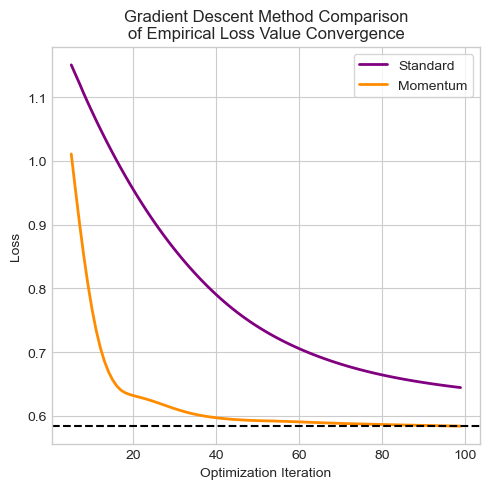

In [15]:
# Plotting the losses for training data
loss_plot(losses_v_tr, losses_m_tr)

*Code above plots the loss value evolution for standard and momentum gradient descent on the training data.*

**Figure 7 (7a above & 7b below)**

Above shows the loss value evolution of the standard and momentum gradient descent models optimizing over the training data.  As expected the loss values decrease over the optimization iterations for both models, but the model using momentum gradient descent minimizes the loss much faster.  Below are the changing model accuracies for the training data.  Inline with the plot above, the accuracies for each model improve during the optimization process, but the model using momentum gradient descent is able to achieve a higher accuracy faster than the model using standard gradient descent.

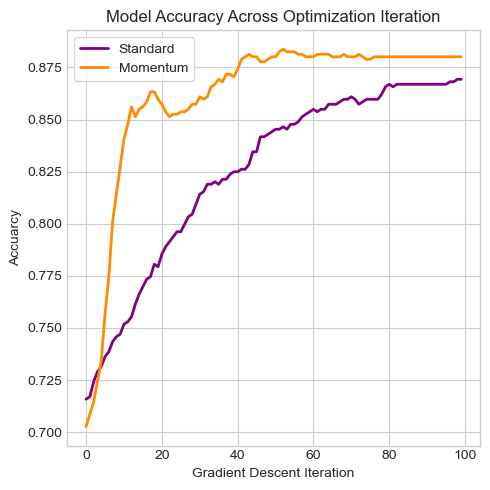

In [16]:
# Plotting the accuracies for training data
acc_plot(accs_v_tr, accs_m_tr)
plt.legend(["Standard", "Momentum"], frameon = True)
plt.tight_layout()

*Code above plots the accuracies for standard and momentum gradient descent on the training data.*

#### **Validation Data Empirical Loss Evolution and Accuracies**

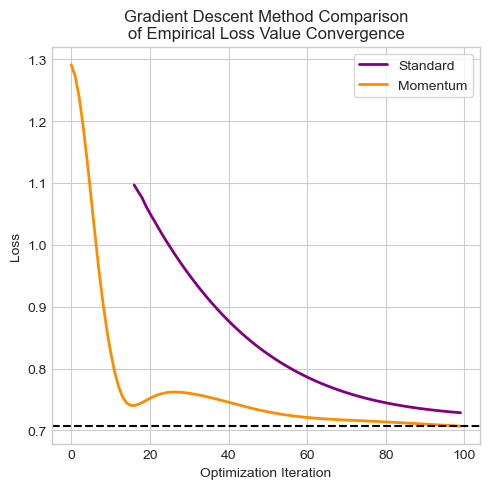

In [17]:
# Plotting the losses for training data
loss_plot(losses_v_val, losses_m_val)

*Code above plots the loss value evolution for standard and momentum gradient descent on the validation data.*

**Figure 8 (8a above & 8b below)**

Above shows the loss value evolution of the standard and momentum gradient descent models now optimizing over the validation data.  Again as expected the loss values decrease over the optimization iterations for both models, and the model using momentum gradient descent continues to minimize the loss much faster.  Below shows the changing model accuracies now for the validation data.  Further aligned with the plot above, the accuracies for each model still improve during the optimization process, and the model using momentum gradient descent is again able to achieve a higher accuracy faster than the model using standard gradient descent.

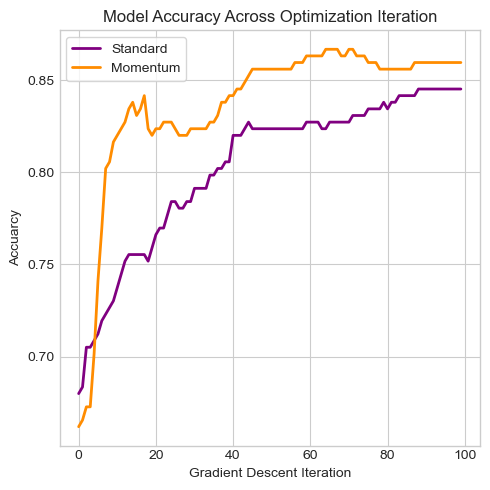

In [18]:
# Plotting the accuracies for training data
acc_plot(accs_v_val, accs_m_val)
plt.legend(["Standard", "Momentum"], frameon = True)
plt.tight_layout()

*Code above plots the accuracies for standard and momentum gradient descent on the validation data.*

#### **Testing Data Empircal Loss Value and Accuracy**

In [19]:
# Evaluating the loss and accuracy of each model on the testing data
loss_v_tst = LR_v.loss(X_test, y_test)
loss_m_tst = LR_m.loss(X_test, y_test)
acc_v_tst = acc(LR_v, X_test, y_test)
acc_m_tst = acc(LR_m, X_test, y_test)

print("Testing Data Empirical Loss:")
print(f"Model 1 (Standard Gradient Descent) | {round(loss_v_tst, 3)}")
print(f"Model 2 (Momentum Gradient Descent) | {round(loss_m_tst, 3)}")
print("-----\n")
print("Testing Data Accuracy:")
print(f"Model 1 (Standard Gradient Descent) | {(round(acc_v_tst, 4) * 100):.2f}%")
print(f"Model 2 (Momentum Gradient Descent) | {(round(acc_m_tst, 4) * 100):.2f}%")

Testing Data Empirical Loss:
Model 1 (Standard Gradient Descent) | 0.622
Model 2 (Momentum Gradient Descent) | 0.538
-----

Testing Data Accuracy:
Model 1 (Standard Gradient Descent) | 89.61%
Model 2 (Momentum Gradient Descent) | 91.04%


*Code above computes the empirical loss and model accuracy on the testing data for each logistic regression model.*

Finally, on the unseen testing data, the model using gradient descent with momentum yields both a lower loss value ($0.538$) and higher accuracy ($91.04\%$) than those of the model using standard gradient descent ($0.622$, $89.61\%$).  Interestingly, both models yield smaller loss values and achieve higher accuracies from the unseen testing data than the training or validation data.

# Conclusion

Over the course of this introductory yet comprehensive exploration of logistic regression, I investigated the fundamental mathematical processes that operate under the hood of logistic regression ML models, implemented my own basic version of a logistic regression model, and evaluated its classification capabilities through a series of experiments.  

Through the four rudimentary experiments, I first examined the rate of convergence/optimization of my logistic regression model by comparing its ability to minimize the empirical loss function using two methods of gradient descent: standard gradient descent and gradient descent with momentum.  Overall, I found that both optimization methods yield desirable results (decreasing the empirical loss value and increasing the classification accuracy over each iteration), but that a model using gradient descent with momentum is able to minimize the empirical loss function and produce a refined weights vector $\mathbf{w}$ much quicker than a model using standard gradient descent.  

I then experimented with overfitting, allowing my model to achieve flawless classification accuracy on training data with more features than data points.  While my model was able to reach $100\%$ accuracy on the training data in very few gradient descent iterations, it was not able to translate its training-data classification abilities to an analogous set of unseen testing data.  In this experiment, I show how while my logistic regression model works effectively for basic classification tasks, it is still subject to overfitting in certain circumstances (which is much like many other ML models out there!).

Lastly, I evaluated the classification performance of my model on a real-world, empirical dataset.  Using a public data set published to [kaggle.com](https://www.kaggle.com/datasets/juice0lover/users-vs-bots-classification?resource=download) by Aleksei Zagorskii, I examined my model's ability to correctly classify data points as either real-human users or bots from public profiles on the popular Russian social media and networking platform VKontakte ([VK.com](https://vk.com/)).  In this final experiment, I opted to select a subset of the data containing only numerical columns to avoid data conversion issues and support expected model behavior.  I had to convert the data from a `pandas` data frame to `torch` tensors and further standardize the data to ensure numerical stability and symmetry and prevent computation errors during the gradient descent optimization process.  Using training, validation, and testing data subsets, I examined the optimization processes and classification abilities of my logistic regression model using both of the gradient descent methods explored previously in this study.  Overall, I found that both gradient descent versions of my model were able to achieve a low empirical loss and fairly high classification accuracy on the real-world data (for training, validation, and testing), but that the model using gradient descent with momentum consistently outperformed the model using standard gradient descent.

Overall, in this analysis I've developed a deeper understanding of the inner-workings of logistic regression and the benefits of different gradient descent methods.  This post provided me with the opportunity to gain more insight into how many classic ML models operate and why certain aspects of their design, like their optimization procedures, are designed cleverly to achieve desirable results faster.  Further, this study gave me experience fitting a custom-built model to real data, exposing me to the difficulties and challenges that come along with preprocessing and standardizing data.

## References

Zagorskii Aleksei. (2025). Users vs bots classification [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DS/6999922